# Test

Statistiken/Daten:
https://data.oecd.org/ict/internet-access.htm
https://data.oecd.org/hha/household-spending.htm
https://data.oecd.org/broadband/households-with-broadband-access.htm
https://data.oecd.org/eduresource/private-spending-on-education.htm
https://data.oecd.org/eduresource/public-spending-on-education.htm
https://en.wikipedia.org/wiki/List_of_countries_by_number_of_households

Korrelationsmatrix um Märkte zu identifizieren die Deutschland ähnlich sind:

U.a. Normalisierung undabhängiger Variablen (5.)
https://towardsdatascience.com/7-steps-to-run-a-linear-regression-analysis-using-r-d5897a66b835

Linear Regression Model Accurancy
http://www.sthda.com/english/articles/40-regression-analysis/167-simple-linear-regression-in-r/

Correlation Matrix
https://www.displayr.com/how-to-create-a-correlation-matrix-in-r/

Idee 1 - vergleichbare Märkte finden:
Deutschland als Erfolgreicher Mark etabliert, ähnliche Märkte sollen gefunden werden.
Zunächst werden die Faktoren, Parameter bestimmt die für Erfolg/Nicht Erfolg verantwortlich sind.
Faktoren: Internetzugriff, Bildungsausgaben, usw -> Korrelationsmatrix (3D) mit Deutschland als Mittelwert 
                                                                                   andere Länder werden damit verglichen (Varianzanalyse)
                                                                                   wenn Werte zu 95% darin liegen (Nullhypothese, Konfidenzintervall)
Ergebnis: Liste mit 10 Kandidaten (Varianz(-bereich))

Idee 2 - Preisberechnung:
Ausgehen vom Preis in Deutschland von 12€/a wird der Anteil der Haushaltsausgaben in Prozent berechnet:
PercentageApp = AppPrice/((Houshold spendings*ExchangeFactor$€)/(Houshold number))
-> 0,00025%
Für alle 10 Kandidaten nun  AppPrice=0,00025%*(Houshold spendings)

In [1]:
library(tidyverse)
library(httr)
library(XML)
library(stringr)

── Attaching packages ────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Download Dataset from OECD website and store them in data frames

In [2]:
df_internet_access <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.INTERNET.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)
df_household_spendings <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HHEXP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)

url <- "https://www.iban.com/country-codes"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))
df_country_codes <- doc[[1]]
names(df_country_codes)[3] <- "LOCATION"
df_country_codes <- subset(df_country_codes, select=c(Country,LOCATION))

df_internet_access <- merge(df_internet_access, df_country_codes,by=c("LOCATION"))
df_household_spendings <- merge(df_household_spendings, df_country_codes,by=c("LOCATION"))

In [3]:
head(df_internet_access)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
1,AUS,INTERNET,TOT,PC_HH,A,2005,60.00,D,Australia
2,AUS,INTERNET,TOT,PC_HH,A,2006,64.00,D,Australia
3,AUS,INTERNET,TOT,PC_HH,A,2007,67.00,D,Australia
4,AUS,INTERNET,TOT,PC_HH,A,2008,72.00,D,Australia
5,AUS,INTERNET,TOT,PC_HH,A,2010,78.92,D,Australia
6,AUS,INTERNET,TOT,PC_HH,A,2012,83.00,D,Australia


In [4]:
head(df_household_spendings)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
1,AUS,HHEXP,TOT,AGRWTH,A,2011,2.857574e+00,,Australia
2,AUS,HHEXP,HOUSING,PC_DI,A,1980,1.336414e+01,,Australia
3,AUS,HHEXP,TOT,MLN_USD,A,1982,1.058935e+05,,Australia
4,AUS,HHEXP,TOT,MLN_USD,A,1981,9.759836e+04,,Australia
5,AUS,HHEXP,TOT,MLN_USD,A,1975,5.249257e+04,,Australia
6,AUS,HHEXP,TOT,MLN_USD,A,1976,5.697552e+04,,Australia


# Normalize and display Internet Access data set

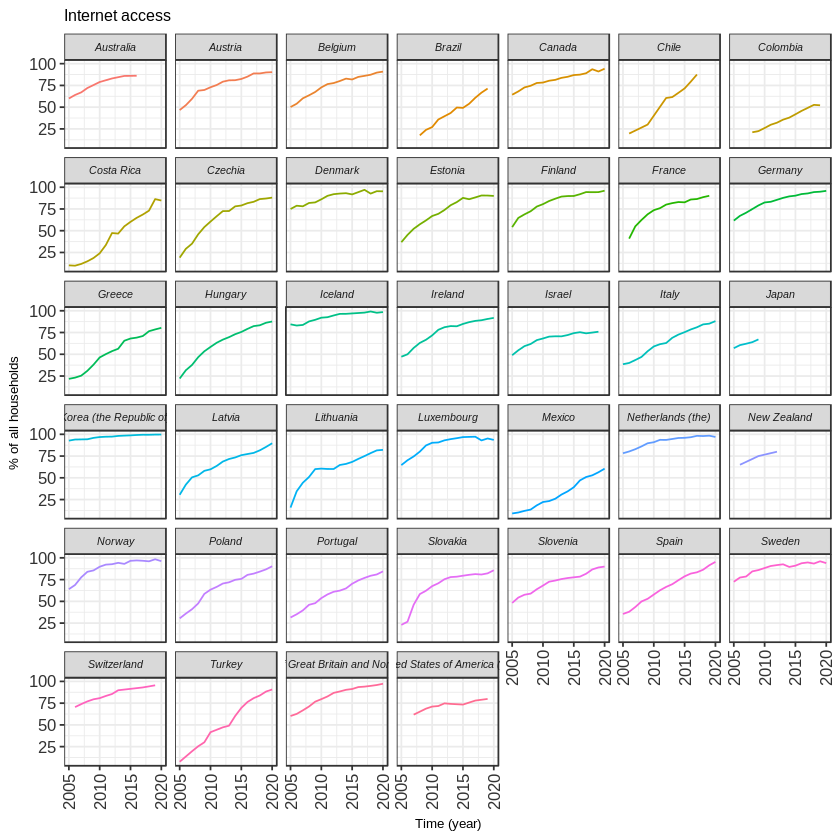

In [5]:
df_internet_access <- df_internet_access[lapply(df_internet_access,length)>0]

#Normalization needed?
#df_internet_access$Value <- (df_internet_access$Value - mean(df_internet_access$Value)) / sd(df_internet_access$Value)

ggplot(data = df_internet_access, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Internet access",
        x = "Time (year)",
        y = "% of all households") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")


# Normalize and display Household Spendings dataset

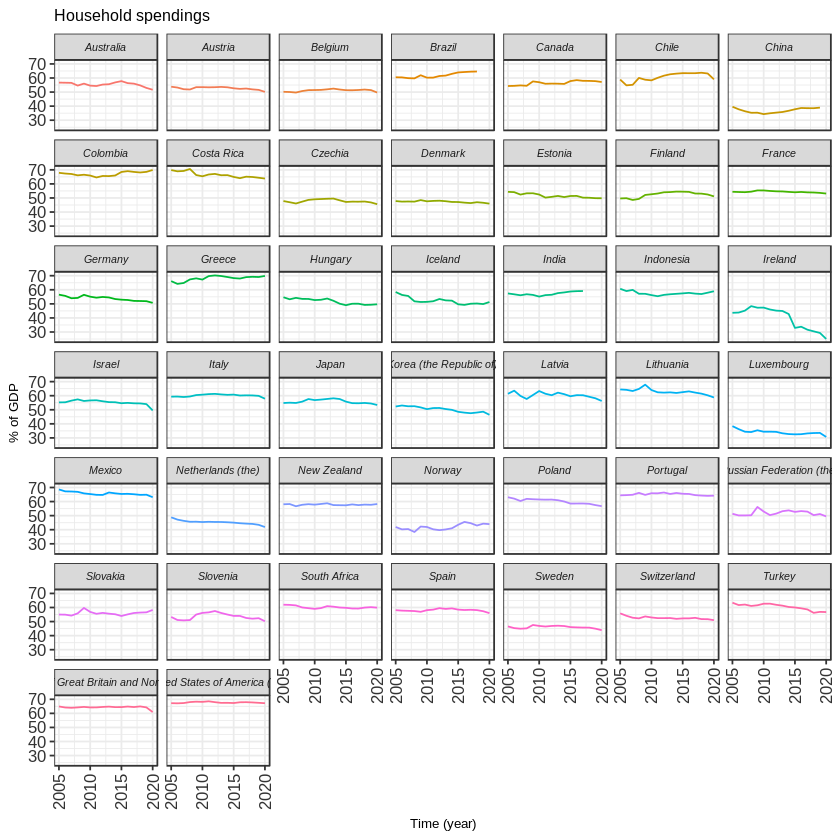

In [6]:
df_household_spendings <- df_household_spendings[lapply(df_household_spendings,length)>0]

df_household_spendings.pcgdp <- df_household_spendings
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, MEASURE == 'PC_GDP')
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, SUBJECT == 'TOT')
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, TIME >= 2005)
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, LOCATION != 'EU' & LOCATION != 'EA')
#Normalization needed?
#df_household_spendings$Value <- log(df_household_spendings$Value)
#df_household_spendings$Value <- (df_household_spendings$Value - min(df_household_spendings$Value)) /(max(df_household_spendings$Value)-min(df_household_spendings$Value))

ggplot(data = df_household_spendings.pcgdp, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "% of GDP") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")

### Normalize spending per inhabitant

In [7]:
url <- "https://en.wikipedia.org/wiki/List_of_countries_by_number_of_households"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))
df_household_numbers <- doc[[2]]
df_household_numbers <- setNames(df_household_numbers, c("Country", "Continent", "Current Population", "Number In Household", 
                                    "Households", "1Member", "2_3Members", "4_5Members", "6Members", "TIME"))

df_household_numbers$TIME <- str_replace_all(df_household_numbers$TIME, "\\[2\\]", "")
df_household_numbers$TIME <- as.integer(df_household_numbers$TIME) 
df_household_numbers <- na.omit(df_household_numbers)
df_household_numbers$Country <- sub("\\W+", "", df_household_numbers$Country)

df_household_numbers <- merge(df_household_numbers, df_country_codes,by="Country")
head(df_household_numbers)

df_household_spendings <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HHEXP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)
df_household_spendings.mlnusd <- subset(df_household_spendings, MEASURE == 'MLN_USD')
df_household_spendings.mlnusd <- na.omit(df_household_spendings.mlnusd)
head(df_household_spendings.mlnusd)

df_spending_per_household <- merge(df_household_numbers, df_household_spendings.mlnusd, by=c("LOCATION", "TIME"))
df_spending_per_household$Households <- str_replace_all(df_spending_per_household$Households, ",", "")
df_spending_per_household$Households <- as.double(df_spending_per_household$Households)
df_spending_per_household$HouseholdSpending <- with(df_spending_per_household, 
                                                    df_spending_per_household$Value*1000000/df_spending_per_household$Households)
head(df_spending_per_household)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,Country,Continent,Current Population,Number In Household,Households,1Member,2_3Members,4_5Members,6Members,TIME,LOCATION
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>
1,Afghanistan,Asia,"32,890,171",8.04,"4,092,477",0.19,6.45,16.84,76.52,2015,AFG
2,Albania,Europe,"2,845,955",3.3,"862,512",9.95,48.08,32.51,9.45,2017,ALB
3,Angola,Africa,"31,127,674",4.82,"6,463,847",10.81,23.90,28.46,36.83,2016,AGO
4,Argentina,South America,"45,376,763",3.26,"13,925,275",17.6,42.33,28.95,11.12,2010,ARG
5,Armenia,Asia,"2,967,900",3.54,"837,896",15.19,36.17,32.30,16.34,2016,ARM
6,Aruba,Caribbean,"112,269",2.89,"38,855",21.37,46.77,25.59,6.28,2010,ABW


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>
1,AUS,HHEXP,TOT,MLN_USD,A,1970,30516.70,
2,AUS,HHEXP,TOT,MLN_USD,A,1971,32843.32,
3,AUS,HHEXP,TOT,MLN_USD,A,1972,35636.84,
4,AUS,HHEXP,TOT,MLN_USD,A,1973,41167.69,
5,AUS,HHEXP,TOT,MLN_USD,A,1974,48525.00,
6,AUS,HHEXP,TOT,MLN_USD,A,1975,52492.57,


,LOCATION,TIME,Country,Continent,Current Population,Number In Household,Households,1Member,2_3Members,4_5Members,6Members,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag.Codes,HouseholdSpending
,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,AUS,2011,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,HHEXP,TOT,MLN_USD,A,533347.9,,52185.73
2,AUT,2011,Austria,Europe,"8,935,112",2.27,3933516,36.34,44.52,17.06,2.08,HHEXP,TOT,MLN_USD,A,194567.0,,49463.90
3,BEL,2011,Belgium,Europe,"11,539,878",2.36,4883743,30.87,48.31,18.70,2.12,HHEXP,TOT,MLN_USD,A,220029.9,,45053.55
4,BRA,2010,Brazil,South America,"212,347,290",3.31,64124398,12.00,47.27,31.91,8.82,HHEXP,TOT,MLN_USD,A,1465039.0,,22846.83
5,CAN,2016,Canada,North America,"38,246,955",2.45,15618491,28.20,49.59,19.20,3.02,HHEXP,TOT,MLN_USD,A,910727.6,,58310.86
6,CHE,2000,Switzerland,Europe,"8,632,703",2.21,3901112,37.51,43.64,17.23,1.62,HHEXP,TOT,MLN_USD,A,141493.6,,36270.08


# Perform linear regression and predict Houshold Spendings for 2021 and 2022


Call:
lm(formula = Value ~ TIME + LOCATION, data = df_household_spendings.pcgdp)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9418  -0.9378   0.0210   0.9246   8.0069 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 286.67158   31.73742   9.033  < 2e-16 ***
TIME         -0.11491    0.01577  -7.287 9.15e-13 ***
LOCATIONAUT  -2.73741    0.67431  -4.060 5.51e-05 ***
LOCATIONBEL  -4.27838    0.67431  -6.345 4.16e-10 ***
LOCATIONBRA   6.35969    0.69815   9.109  < 2e-16 ***
LOCATIONCAN   1.04372    0.67431   1.548 0.122145    
LOCATIONCHE  -2.76930    0.67431  -4.107 4.52e-05 ***
LOCATIONCHL   5.19822    0.67431   7.709 4.74e-14 ***
LOCATIONCHN -18.53919    0.68550 -27.045  < 2e-16 ***
LOCATIONCOL  11.78299    0.67431  17.474  < 2e-16 ***
LOCATIONCRI  11.06476    0.67431  16.409  < 2e-16 ***
LOCATIONCZE  -7.64888    0.67431 -11.343  < 2e-16 ***
LOCATIONDEU  -1.55299    0.67431  -2.303 0.021586 *  
LOCATIONDNK  -8.12149    0.67431 -12.044  <

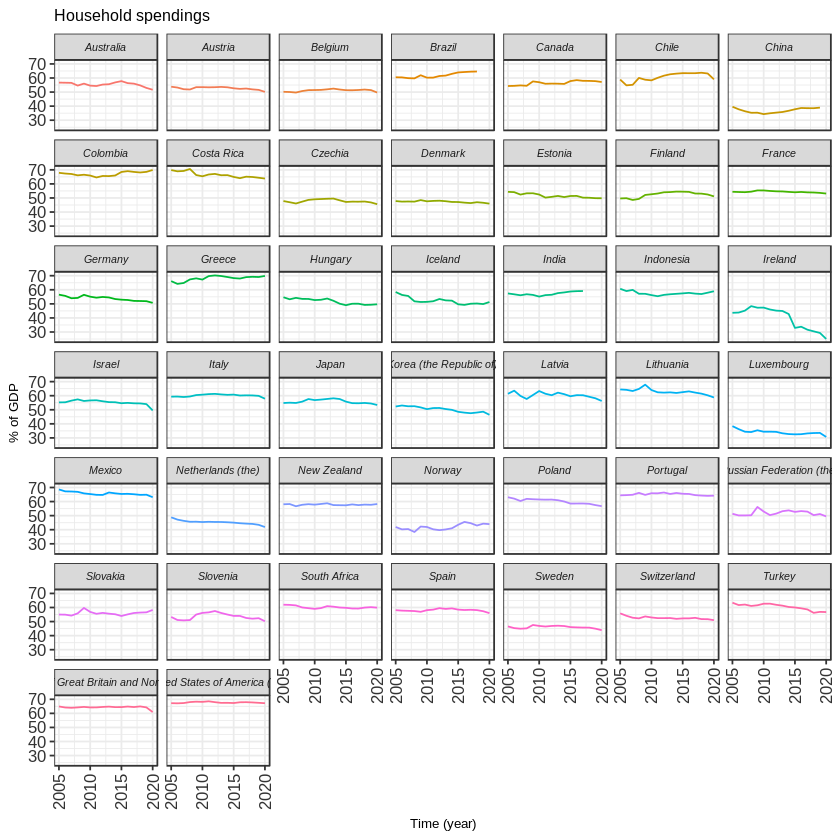

In [8]:
model = lm(Value ~ TIME + LOCATION, data = df_household_spendings.pcgdp) #Create the linear regression
summary(model) #Review the results

#LOCATION <- unique(df_household_spendings.pcgdp$LOCATION, incomparables = FALSE)

#df <- data.frame(LOCATION, INDICATOR='HHEXP', SUBJECT='TOT', MEASURE='PC_GDP', FREQUENCY='A', TIME=2021, Value=0.0, Flag.Codes='', Country='')
#df$Value <- predict(model, df)
#df_household_spendings.pcgdp<-merge(df_household_spendings.pcgdp, df, by=c("LOCATION"))
#df_household_spendings.pcgdp <- rbind(df_household_spendings.pcgdp, df)

#df <- data.frame(LOCATION, INDICATOR='HHEXP', SUBJECT='TOT', MEASURE='PC_GDP', FREQUENCY='A', TIME=2022, Value=0.0, Flag.Codes='', Country='')
#df$Value <- predict(model, df)
#df_household_spendings.pcgdp<-merge(df_household_spendings.pcgdp, df, by=c("LOCATION"))
#df_household_spendings.pcgdp <- rbind(df_household_spendings.pcgdp, df)
#df_household_spendings.pcgdp

#df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, TIME >= 2020)
ggplot(data = df_household_spendings.pcgdp, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "% of GDP") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")

# Correlation between Household Spendings (% of GDP) and Internet Access (% of all households)

,LOCATION,CORR
,<fct>,<dbl>
11,DEU,-0.8076428


,LOCATION,CORR
,<fct>,<dbl>
12,DNK,-0.5810579
26,LTU,-0.5876214
20,IRL,-0.6835812
6,CHE,-0.6994065
29,MEX,-0.7694886
21,ISL,-0.7999600
27,LUX,-0.8111906
33,POL,-0.8366786
30,NLD,-0.8387857


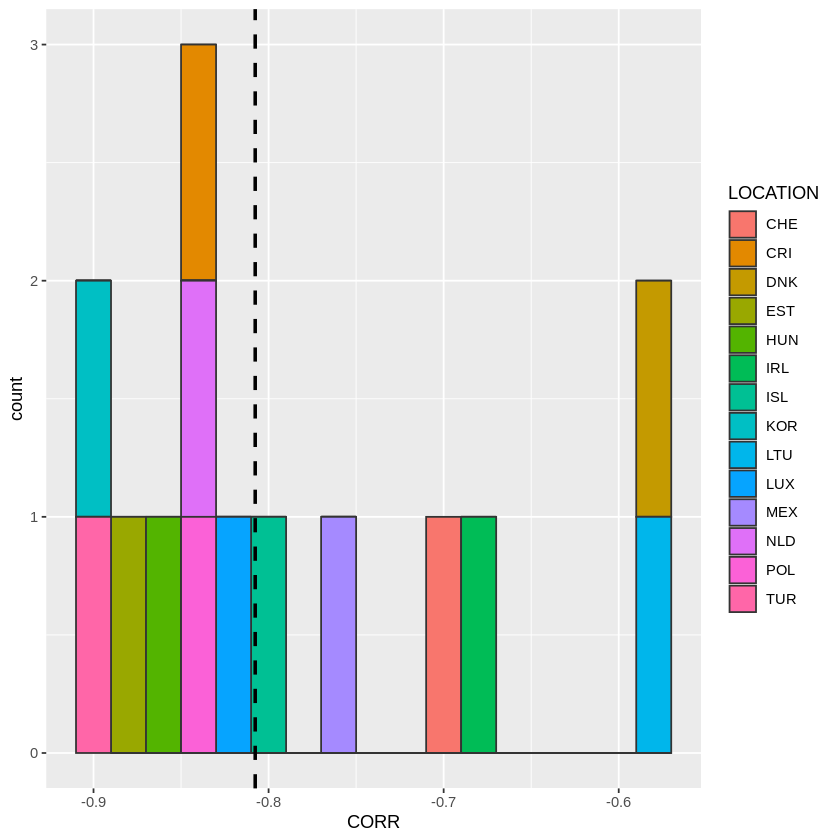

In [9]:
df <- merge(df_household_spendings.pcgdp, df_internet_access,by=c("LOCATION","TIME"))
xx <- data.frame(group = df$LOCATION, a = df$Value.x , b = df$Value.y )

# This returns a "by" object
result <- by(xx[,2:3], xx$group, function(x) {cor(x$b, x$a)})

# You get pretty close to what you want if you coerce it into a data frame via a matrix
result.dataframe <- as.data.frame(as.matrix(result))
result.dataframe <- na.omit(result.dataframe)

result.dataframe <- cbind(newColName = rownames(result.dataframe), result.dataframe)
rownames(result.dataframe) <- 1:nrow(result.dataframe)

colnames(result.dataframe) <- c("LOCATION","CORR")
result.dataframe <- result.dataframe[order(result.dataframe$CORR,decreasing=TRUE), ]

germany <- result.dataframe[result.dataframe$LOCATION == 'DEU', ]
germany

result.dataframe <- result.dataframe[result.dataframe$CORR <= -0.55 & result.dataframe$CORR >= -1.0 & result.dataframe$LOCATION != 'DEU', ]
result.dataframe

ggplot(aes(x = CORR ), data = result.dataframe) + 
  geom_histogram(aes(fill = LOCATION ), binwidth=0.02, colour="grey20") +
  geom_vline(aes(xintercept=germany$CORR), color="black", linetype="dashed", size=1)


## correlation coefficients for a set of variables used to determine if a relationship exists between the variables. The coefficient indicates both the strength of the relationship as well as the direction (positive vs. negative correlations)

In [10]:
df_germany <- subset(df_spending_per_household, LOCATION == 'DEU')

#df_single <- str_replace_all(df_germany$V6, ",", ".")
#df_single <- as.double(df_single)/100.0
#df_single

url <- "https://www.xe.com/currencyconverter/convert/?Amount=1&From=EUR&To=USD"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))

xe <- doc[[1]]
xe <- xe[1,]

xe.dollar <- str_replace_all(xe$USD, "USD", "")
xe.dollar <- as.double(xe.dollar)
#xe.dollar

app.price.eur <- 12
app.price.dollar <- app.price.eur * xe.dollar
app.percentage.spending <- (app.price.dollar)/(df_germany$HouseholdSpending)
app.percentage.spending 

[1] 0.0003129145

In [11]:

df_final <- merge(df_spending_per_household, result.dataframe, by=c("LOCATION"))
df_final$AppPrice <- with(df_final, df_final$HouseholdSpending*app.percentage.spending )
df_final
df_final <- df_final[c("Country","AppPrice")]
df_final

LOCATION,TIME,Country,Continent,Current Population,Number In Household,Households,1Member,2_3Members,4_5Members,6Members,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag.Codes,HouseholdSpending,CORR,AppPrice
<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
CHE,2000,Switzerland,Europe,"8,632,703",2.21,3901112,37.51,43.64,17.23,1.62,HHEXP,TOT,MLN_USD,A,141493.64,,36270.08,-0.6994065,11.349435
CRI,2011,Costa Rica,Central America,"5,111,238",3.46,1476628,11.23,42.7,35.83,10.25,HHEXP,TOT,MLN_USD,A,42797.35,,28983.16,-0.8495067,9.069254
EST,2011,Estonia,Europe,"1,328,976",2.3,578440,33.90,47.28,17.14,1.67,HHEXP,TOT,MLN_USD,A,14256.86,,24647.09,-0.8884881,7.712433
HUN,2011,Hungary,Europe,"9,769,526",2.6,3753000,23.63,50.92,22.72,2.74,HHEXP,TOT,MLN_USD,A,108221.51,,28836.00,-0.8692882,9.023204
IRL,2011,Ireland,Europe,"4,977,400",2.77,1799221,21.58,48.05,26.21,4.16,HHEXP,TOT,MLN_USD,A,82315.11,,45750.42,-0.6835812,14.315971
LTU,2011,Lithuania,Europe,"2,794,870",2.32,1204383,34.71,45.4,18.00,1.89,HHEXP,TOT,MLN_USD,A,37766.24,,31357.34,-0.5876214,9.812167
LUX,2011,Luxembourg,Europe,"626,108",2.41,259519,32.30,44.15,21.45,2.10,HHEXP,TOT,MLN_USD,A,15742.98,,60662.15,-0.8111906,18.982070
MEX,2015,Mexico,North America,"127,792,286",3.74,34167462,10.08,37.68,37.75,14.49,HHEXP,TOT,MLN_USD,A,1287779.30,,37690.22,-0.7694886,11.793819
POL,2011,Poland,Europe,"38,352,000",2.81,13666831,20.67,49.49,24.80,5.04,HHEXP,TOT,MLN_USD,A,500236.70,,36602.25,-0.8366786,11.453375


Country,AppPrice
<chr>,<dbl>
Switzerland,11.349435
Costa Rica,9.069254
Estonia,7.712433
Hungary,9.023204
Ireland,14.315971
Lithuania,9.812167
Luxembourg,18.982070
Mexico,11.793819
Poland,11.453375
